# Introduction



This notebook accompanies my Medium.com blogpost **"Networked Narratives: Leveraging LLMs and GNNs for Next-Generation Knowledge Graphs"**, describing how to utilize LLMs + LangChain and graph neural networks (GNNs) to extract knowledge graphs from text.

# Lib imports

In [ ]:
from dotenv import load_dotenv
import os

import torch
import torch_geometric as pyg
import torch.nn.functional as F
import torch.nn as nn

import torch_geometric.nn as pyg_nn
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from pydantic import BaseModel, Field
from sklearn.decomposition import PCA
from tqdm.auto import tqdm
from adjustText import adjust_text
from sklearn.metrics import classification_report
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_experimental.graph_transformers.llm import LLMGraphTransformer
from langchain_community.document_loaders import WikipediaLoader
from langchain_core.documents import Document
from collections import defaultdict
import hextractor.visualization as viz

from hextractor.integrations.langchain_graphdoc import (
    convert_graph_document_to_hetero_data,
)
from hextractor.structures import VisualizationConfig

from torch_geometric.transforms import RandomLinkSplit, ToUndirected

In [ ]:
load_dotenv(override=True)

True

# LLM setup

If you are about to use the LLM - you need to configure it properly with the API keys, etc.

In [ ]:
llm = ChatOpenAI(
    model_name="openai/gpt-4.1-mini",
    openai_api_key="YOUR KEY HERE",
    base_url="URL HERE",
    temperature=0.0,
)
llm.invoke("Hello do you respond?")

AIMessage(content='Hello! Yes, I’m here and ready to help. How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 12, 'total_tokens': 31, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'openai/gpt-4.1-mini', 'system_fingerprint': None, 'id': 'gen-1752483223-S8fHXkeuF3EqzPlo6xEl', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--0ae01e0f-d92e-4e9f-a474-5d642206d2fa-0', usage_metadata={'input_tokens': 12, 'output_tokens': 19, 'total_tokens': 31, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})

# Article text reading

In [ ]:
preload_doc = True
if preload_doc:
    doc = Document(page_content="\n".join(open("wiki_docs.txt", "r").readlines()))
else:
    wiki_docs = WikipediaLoader(query="Machine learning", load_max_docs=5, doc_content_chars_max=10_000, lang='en').load()
    merged_doc = Document(
        page_content=" ".join([f"{doc.metadata['title']} \n === \n {doc.page_content}" for doc in wiki_docs]),
        metadata={"source": "wiki"},
    )
    open("wiki_docs.txt", "w").write(merged_doc.page_content)

In [ ]:
print(doc.page_content[:500])

Machine learning 

 === 

 Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.

ML finds 


# Graph exttraction with LLM

## Manual approach with structured output

In [ ]:
class Node(BaseModel):
    id: str = Field(description="Node ID - a unique full name for the node.")
    type: str = Field(
        description="Node type, a string representing the type of the node. E.g.: person, organization or place"
    )


class Edge(BaseModel):
    source: Node = Field(description="Source node in the relation")
    target: Node = Field(description="Target node in the relation")
    type: str = Field(description="Type of the edge in the relation")


class Graph(BaseModel):
    nodes: list[Node] = Field(description="List of nodes in the graph.")
    relationships: list[Edge] = Field(description="List of edges in the graph.")

In [ ]:
preload_manual_llm_output = True

if preload_manual_llm_output:
    manual_graph_from_text = joblib.load("manual_graph_from_text.pkl")
else:
    llm_with_structured_output = llm.with_structured_output(Graph)

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """
        You are a helpful assistant for extracting structured knowledge graphs from text. Your task is to read the provided text and convert it into a graph structure following the given schema.

        For each input, identify and extract:
        - Concepts, disciplines, and the relationships between them
        - People, organizations, and places mentioned in the text
        - Associations and interactions among these entities

        For each relationship, use clear and general relation names that can be applied consistently across different contexts (e.g., 'works_at', 'is_subfield_of', 'contributed_to'). Ensure that every node referenced in an edge is also present in the nodes list.

        Focus on capturing meaningful associations, especially those involving concepts, disciplines, and people. Be comprehensive but concise, and avoid duplicating nodes or relationships.

        Return the result as a graph object according to the schema.
        """
            ),
            ("user", "{text_input}"),
        ]
    )

    query = prompt.format(text_input=doc.page_content)

    manual_graph_from_text = llm_with_structured_output.invoke(query)
    joblib.dump(manual_graph_from_text, "manual_graph_from_text.pkl")

In [ ]:
manual_graph_from_text.nodes[:5]

[Node(id='Machine learning', type='Concept'),
 Node(id='Artificial intelligence', type='Concept'),
 Node(id='Deep learning', type='Concept'),
 Node(id='Neural networks', type='Concept'),
 Node(id='Statistics', type='Concept')]

In [ ]:
manual_graph_from_text.relationships[:5]

[Edge(source=Node(id='Machine learning', type='Concept'), target=Node(id='Artificial intelligence', type='Concept'), type='is_subfield_of'),
 Edge(source=Node(id='Deep learning', type='Concept'), target=Node(id='Machine learning', type='Concept'), type='is_subfield_of'),
 Edge(source=Node(id='Neural networks', type='Concept'), target=Node(id='Machine learning', type='Concept'), type='is_model_used_in'),
 Edge(source=Node(id='Statistics', type='Concept'), target=Node(id='Machine learning', type='Concept'), type='is_foundation_of'),
 Edge(source=Node(id='Mathematical optimisation', type='Concept'), target=Node(id='Machine learning', type='Concept'), type='is_foundation_of')]

In [ ]:
nx_graph = nx.DiGraph()
for node_type in manual_graph_from_text.nodes:
    nx_graph.add_node(node_type.id, node_type=node_type.type)

for edge in manual_graph_from_text.relationships:
    nx_graph.add_edge(edge.source.id, edge.target.id, edge_type=edge.type)

/tmp/ipykernel_208528/1481073137.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


(np.float64(-0.7330978140462326),
 np.float64(1.164683502692176),
 np.float64(-0.8003840877427773),
 np.float64(0.9967174881734406))

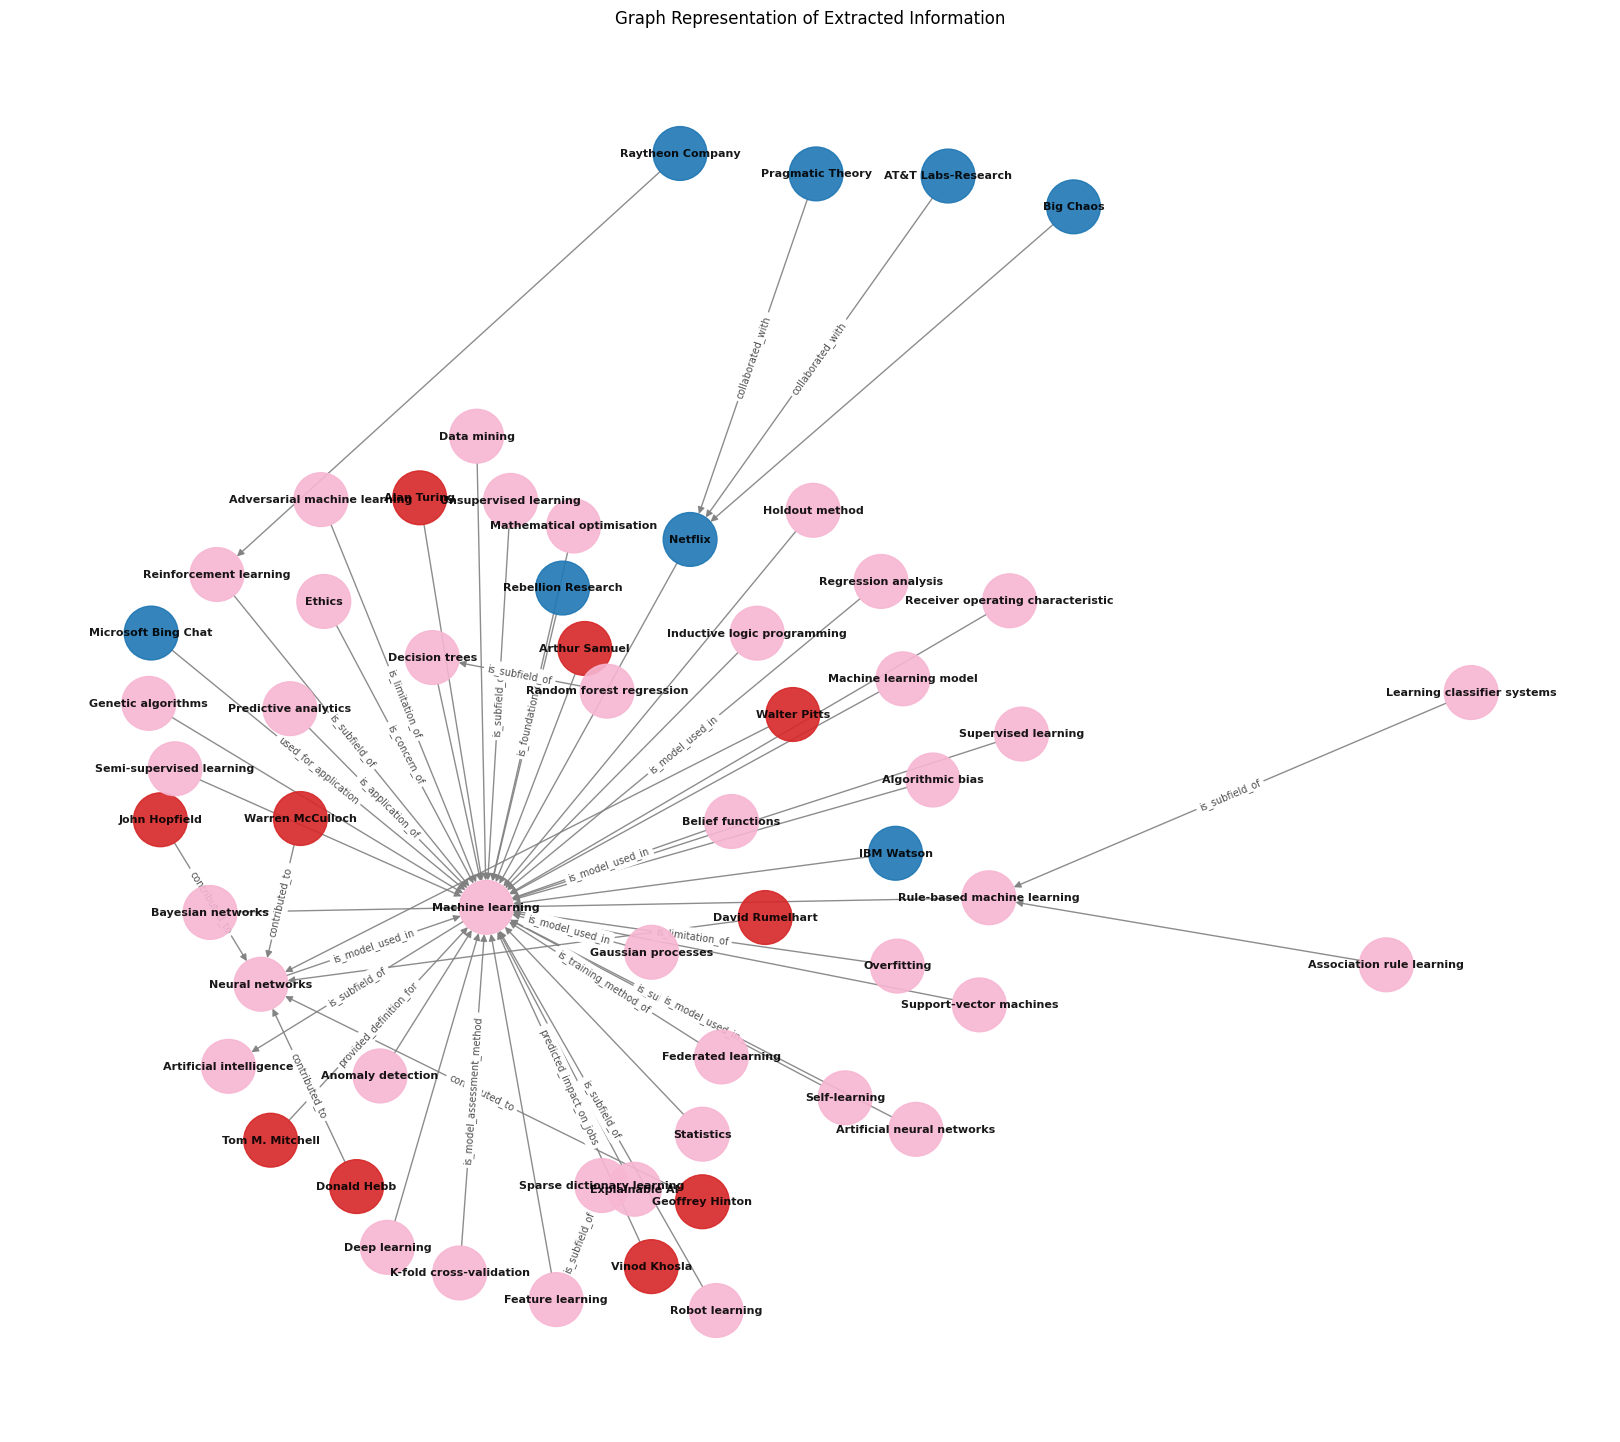

In [ ]:
plt.figure(figsize=(16, 14))  # Increase figure size for more space

# Get edge attributes for edge labels
edge_labels = {
    (source, target): data["edge_type"]
    for source, target, data in nx_graph.edges(data=True)
}

# Get node types for coloring
node_types = nx.get_node_attributes(nx_graph, "node_type")
unique_types = set(node_types.values())
color_map = {t: plt.cm.tab20(i / len(unique_types)) for i, t in enumerate(unique_types)}
node_colors = [color_map[node_types[node]] for node in nx_graph.nodes()]

# Use spring layout with increased k value for more spread and more iterations
pos = nx.spring_layout(nx_graph, k=0.5, iterations=100, seed=1)

# Draw the graph with nodes
nx.draw(
    nx_graph,
    pos,
    with_labels=True,
    node_size=1500,
    node_color=node_colors,
    font_size=8,
    font_weight="bold",
    alpha=0.9,
    width=1,
    edge_color="gray",
)

# Only draw a subset of edge labels to reduce clutter
# Take every other edge to reduce density
edges_to_show = list(edge_labels.keys())[::2]
filtered_edge_labels = {k: edge_labels[k] for k in edges_to_show}
nx.draw_networkx_edge_labels(
    nx_graph, pos, edge_labels=filtered_edge_labels, font_size=7, alpha=0.7
)

plt.title("Graph Representation of Extracted Information")
plt.tight_layout()
plt.axis("off")  # Turn off axis for cleaner look

## Langchain Graph transformer

In [ ]:
load_precomputed_graph_doc = True
if load_precomputed_graph_doc:
    graph_doc = joblib.load("graph_doc.pkl")
else:
    transformer = LLMGraphTransformer(llm=llm)
    graph_doc = transformer.convert_to_graph_documents([doc])
    joblib.dump(graph_doc, "graph_doc.pkl")

In [ ]:
graph_doc[0].nodes[:20]

[Node(id='Machine Learning', type='Concept', properties={}),
 Node(id='Artificial Intelligence', type='Concept', properties={}),
 Node(id='Deep Learning', type='Concept', properties={}),
 Node(id='Neural Networks', type='Concept', properties={}),
 Node(id='Statistics', type='Concept', properties={}),
 Node(id='Mathematical Optimisation', type='Concept', properties={}),
 Node(id='Data Mining', type='Concept', properties={}),
 Node(id='Predictive Analytics', type='Concept', properties={}),
 Node(id='Arthur Samuel', type='Person', properties={}),
 Node(id='Donald Hebb', type='Person', properties={}),
 Node(id='Walter Pitts', type='Person', properties={}),
 Node(id='Warren Mcculloch', type='Person', properties={}),
 Node(id='Cybertron', type='Concept', properties={}),
 Node(id='Raytheon Company', type='Organization', properties={}),
 Node(id='Nilsson', type='Person', properties={}),
 Node(id='Tom M. Mitchell', type='Person', properties={}),
 Node(id='Alan Turing', type='Person', properties

# Hetero data extraction

## Manual extraction

In [ ]:
# Extract all nodes and edges from the graph document
nodes = manual_graph_from_text.nodes
edges = manual_graph_from_text.relationships

# Create dictionaries to store nodes by type
nodes_by_type = {}
for node in nodes:
    node_type = node.type.lower()  # Normalize node types to lowercase
    if node_type not in nodes_by_type:
        nodes_by_type[node_type] = []
    nodes_by_type[node_type].append(node.id)

# Create id mappings for each node type (str -> int)
node_id_mappings = {}
for node_type, node_ids in nodes_by_type.items():
    node_id_mappings[node_type] = {node_id: idx for idx, node_id in enumerate(node_ids)}

# Create edge_index tensors for each relation type
edge_indices_by_type = {}
for edge in edges:
    source_type = edge.source.type.lower()
    target_type = edge.target.type.lower()
    edge_type = edge.type
    
    edge_key = (source_type, edge_type, target_type)
    
    if edge_key not in edge_indices_by_type:
        edge_indices_by_type[edge_key] = []
    
    # Get numeric IDs for source and target
    source_id = node_id_mappings[source_type][edge.source.id]
    target_id = node_id_mappings[target_type][edge.target.id]
    
    edge_indices_by_type[edge_key].append([source_id, target_id])

# Convert edge lists to tensors
for edge_key in edge_indices_by_type:
    edges_list = edge_indices_by_type[edge_key]
    edge_indices_by_type[edge_key] = torch.tensor(edges_list, dtype=torch.long).t()

# Create node features for each node type using one-hot encoding
x_dict = {}
for node_type, node_ids in nodes_by_type.items():
    num_nodes = len(node_ids)
    
    # Create one-hot encoded features for each node
    # For each node type, we create a matrix where:
    # - Rows represent individual nodes of this type
    # - Each row is a one-hot vector where a single position is 1 and others are 0
    # - This effectively gives each node a unique identity
    one_hot = torch.eye(num_nodes)  # Identity matrix creates perfect one-hot vectors
    
    # Store the one-hot encoded feature matrix for this node type
    x_dict[node_type] = one_hot

# Create the heterogeneous graph
hetero_data_manual = pyg.data.HeteroData()

# Add node features
for node_type, features in x_dict.items():
    hetero_data_manual[node_type].x = features

# Add edge indices
for (src_type, edge_type, dst_type), edge_index in edge_indices_by_type.items():
    hetero_data_manual[src_type, edge_type, dst_type].edge_index = edge_index

hetero_data_manual

HeteroData(
  concept={ x=[40, 40] },
  person={ x=[10, 10] },
  organization={ x=[8, 8] },
  (concept, is_subfield_of, concept)={ edge_index=[2, 16] },
  (concept, is_model_used_in, concept)={ edge_index=[2, 10] },
  (concept, is_foundation_of, concept)={ edge_index=[2, 2] },
  (concept, is_related_to, concept)={ edge_index=[2, 1] },
  (concept, is_application_of, concept)={ edge_index=[2, 1] },
  (person, coined_term_for, concept)={ edge_index=[2, 1] },
  (person, contributed_to, concept)={ edge_index=[2, 6] },
  (organization, developed_early_machine, concept)={ edge_index=[2, 1] },
  (person, provided_definition_for, concept)={ edge_index=[2, 1] },
  (person, influenced_definition_of, concept)={ edge_index=[2, 1] },
  (concept, is_component_of, concept)={ edge_index=[2, 1] },
  (concept, is_training_method_of, concept)={ edge_index=[2, 1] },
  (organization, used_for_application, concept)={ edge_index=[2, 4] },
  (organization, collaborated_with, organization)={ edge_index=[2, 3] }

## HeXtractor utility package

In [ ]:
hetero_data, node_id_mapping = convert_graph_document_to_hetero_data(
    manual_graph_from_text
)

In [ ]:
hetero_data

HeteroData(
  Concept={ x=[40, 1] },
  Person={ x=[10, 1] },
  Organization={ x=[8, 1] },
  (Organization, developed_early_machine, Concept)={ edge_index=[2, 1] },
  (Concept, is_model_used_in, Concept)={ edge_index=[2, 10] },
  (Person, contributed_to, Concept)={ edge_index=[2, 6] },
  (Person, influenced_definition_of, Concept)={ edge_index=[2, 1] },
  (Concept, is_component_of, Concept)={ edge_index=[2, 1] },
  (Concept, is_training_method_of, Concept)={ edge_index=[2, 1] },
  (Concept, is_limitation_of, Concept)={ edge_index=[2, 3] },
  (Concept, is_application_of, Concept)={ edge_index=[2, 1] },
  (Concept, is_subfield_of, Concept)={ edge_index=[2, 16] },
  (Concept, is_concern_of, Concept)={ edge_index=[2, 1] },
  (Person, coined_term_for, Concept)={ edge_index=[2, 1] },
  (Organization, used_for_application, Concept)={ edge_index=[2, 4] },
  (Concept, is_related_to, Concept)={ edge_index=[2, 1] },
  (Person, predicted_impact_on_jobs, Concept)={ edge_index=[2, 1] },
  (Concept, i

In [ ]:
mapped_node_names = defaultdict(lambda: dict())
for (type, name), id in node_id_mapping.items():
    mapped_node_names[type][id] = name

In [ ]:
# Create a color palette with enough distinct colors for all node types
colors = [
    "red",
    "blue",
    "green",
    "orange",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
    "magenta",
    "yellow",
    "teal",
    "navy",
    "coral",
    "maroon",
    "lime",
    "indigo",
    "violet",
    "turquoise",
]

simple_cfg = dict(
    node_types_to_colors={
        node: colors[node_idx % len(colors)]
        for node_idx, node in enumerate(hetero_data.node_types)
    },
    edge_type_to_colors={e: "black" for e in hetero_data.edge_types},
    node_type_label_attr_name={node: "x" for node in hetero_data.node_types},
    node_type_label_attr_idx={node: 0 for node in hetero_data.node_types},
    notebook_visualization=True,
)


simple_viz_cfg = VisualizationConfig(**simple_cfg)
simple_net_viz = viz.VisualizationBuilder.build_visualization(
    simple_viz_cfg, hetero_data, mapped_node_names
)

# Warning - visualization does not show up in VSCode
simple_net_viz.show(name="llm_graph.html")

# Nodes embbedding

## Graph prep

In [ ]:
hetero_data

HeteroData(
  Concept={ x=[40, 1] },
  Person={ x=[10, 1] },
  Organization={ x=[8, 1] },
  (Organization, developed_early_machine, Concept)={ edge_index=[2, 1] },
  (Concept, is_model_used_in, Concept)={ edge_index=[2, 10] },
  (Person, contributed_to, Concept)={ edge_index=[2, 6] },
  (Person, influenced_definition_of, Concept)={ edge_index=[2, 1] },
  (Concept, is_component_of, Concept)={ edge_index=[2, 1] },
  (Concept, is_training_method_of, Concept)={ edge_index=[2, 1] },
  (Concept, is_limitation_of, Concept)={ edge_index=[2, 3] },
  (Concept, is_application_of, Concept)={ edge_index=[2, 1] },
  (Concept, is_subfield_of, Concept)={ edge_index=[2, 16] },
  (Concept, is_concern_of, Concept)={ edge_index=[2, 1] },
  (Person, coined_term_for, Concept)={ edge_index=[2, 1] },
  (Organization, used_for_application, Concept)={ edge_index=[2, 4] },
  (Concept, is_related_to, Concept)={ edge_index=[2, 1] },
  (Person, predicted_impact_on_jobs, Concept)={ edge_index=[2, 1] },
  (Concept, i

In [ ]:
target_rel = ("Concept", "is_subfield_of", "Concept")

hetero_g_undir = ToUndirected()(hetero_data)
for node_type in hetero_data.node_types:
    hetero_g_undir[node_type].x = torch.atleast_2d(
        nn.functional.one_hot(hetero_g_undir[node_type].x.to(torch.int64)).squeeze()
    ).to(torch.float32)

train_g, val_g, test_g = RandomLinkSplit(
    add_negative_train_samples=True,
    neg_sampling_ratio=2.0,
    num_val=3,
    num_test=0,
    disjoint_train_ratio=0.5,
    edge_types=[target_rel],
)(hetero_g_undir)

## Model prep

In [ ]:
class LinkPredictor(nn.Module):
    """
    A link prediction model that predicts whether an edge exists between two nodes.

    This model first uses a GNN to generate node embeddings, then predicts links by
    concatenating the embeddings of source and target nodes and passing them through
    a prediction head.
    """

    def __init__(
        self,
        gnn_conv,  # GNN model that generates node embeddings
        dim_in: int = 8,  # Dimension of each node embedding
        hidden_dim: int = 8,  # Hidden dimension of prediction MLP
        relation: tuple[str, str, str] = target_rel,
    ):  # Target relation to predict (src_type, edge_type, dst_type)
        super().__init__()
        self.gnn_conv = gnn_conv  # GNN model for node embedding generation
        # MLP for predicting links: first maps concatenated embeddings to hidden dimension
        self.prediction_head = nn.Linear(dim_in * 2, hidden_dim)
        # Output layer maps hidden representation to a single score
        self.out = nn.Linear(hidden_dim, 1)
        # Store the target relation for reference
        self.target_rel = relation
        # Extract source and destination node types from the relation
        self.src_node_type = relation[0]
        self.dst_node_type = relation[2]

    def forward(self, hetero_g: pyg.data.HeteroData):
        """
        Forward pass for link prediction.

        Args:
            hetero_g: A heterogeneous graph with node features and edge_label_index
                     containing node pairs to evaluate for link prediction.

        Returns:
            Tensor of link prediction scores (logits)
        """
        # Generate embeddings for all nodes using the GNN
        node_embed = self.gnn_conv(hetero_g.x_dict, hetero_g.edge_index_dict)

        # Get indices of source nodes for the edges we need to predict
        src_idx = hetero_g[self.target_rel].edge_label_index[0, :]
        # Extract embeddings for source nodes
        src_embed = node_embed[self.src_node_type][src_idx]

        # Get indices of destination nodes
        dst_idx = hetero_g[self.target_rel].edge_label_index[1, :]
        # Extract embeddings for destination nodes
        dst_embed = node_embed[self.dst_node_type][dst_idx]

        # Concatenate source and destination embeddings to represent the potential edge
        x = torch.cat([src_embed, dst_embed], dim=1)
        # Pass through first layer of prediction MLP
        x = self.prediction_head(x)
        # Note: ReLU activation is commented out, but could be added for non-linearity
        # x = F.relu(x)
        # Output layer produces final prediction score
        x = self.out(x)
        return x

## Model training

In [ ]:

"""The definition of the hetero GNN convolution layer.
1. We first create a "prototype" model with lazy initialization of input (-1, -1);
2. Then we convert it to a heterogeneous model using the metadata of the graph - this is handled by the PyG library;
"""

pyg.seed_everything(123)
sage = pyg_nn.GraphSAGE(
    in_channels=(-1, -1), hidden_channels=16, out_channels=16, num_layers=2, aggr=["sum", "mean"], dropout=0.5, normalize=True, jk='cat'
)
gnn_conv_hetero = pyg_nn.to_hetero(
    sage, hetero_g_undir.metadata(), aggr="mean"
)

with torch.no_grad():
    x = gnn_conv_hetero(hetero_g_undir.x_dict, hetero_g_undir.edge_index_dict)
predictor = LinkPredictor(gnn_conv_hetero, dim_in=16, hidden_dim=8)

optimizer = torch.optim.Adam(predictor.parameters(), lr=0.01)
train_losses = []
val_losses = []
epochs = 30

for epoch in tqdm(range(epochs), desc="Epochs"):
    predictor.train()
    epoch_loss = 0
    optimizer.zero_grad()
    out = predictor(train_g).squeeze()
    loss = F.binary_cross_entropy_with_logits(
        out, train_g[predictor.target_rel].edge_label.float()
    )
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    train_losses.append(epoch_loss)
    predictor.eval()
    with torch.no_grad():
        out = predictor(val_g).squeeze()
        val_loss = F.binary_cross_entropy_with_logits(
            out, val_g[predictor.target_rel].edge_label.float()
        )
        val_losses.append(val_loss.item())
    epoch_loss /= len(val_g)
    if epoch % 1 == 0:
        print(f"Epoch {epoch}: Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")
    else:
        print(f"Epoch {epoch}: Train Loss: {epoch_loss:.4f}")


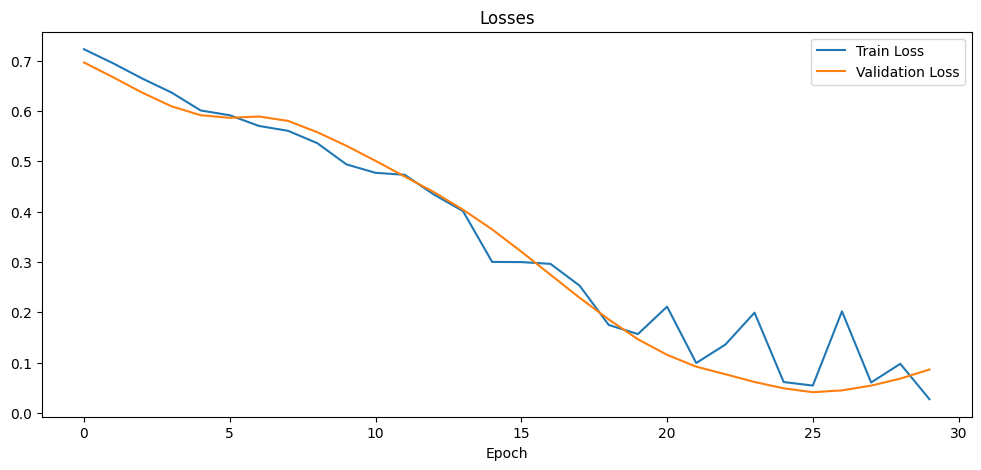

In [ ]:
fig, axes = plt.subplots(figsize=(12, 5))
axes.plot(train_losses, label="Train Loss")
axes.plot(val_losses, label="Validation Loss")
axes.set_title("Losses")
axes.set_xlabel("Epoch")
axes.legend()
plt.show();

In [ ]:
predictor.eval()
with torch.no_grad():
    yhat_val = predictor(val_g).squeeze()
    yhat_test = predictor(test_g).squeeze()

Test results are just a side-effect. The model is trained for the embedding, and on the small sample size.

In [ ]:
print(
    classification_report(
        y_true=val_g[predictor.target_rel].edge_label.cpu().numpy(),
        y_pred=(yhat_val > 0).cpu().numpy(),
        target_names=["Negative sample", "True rel"],
    )
)

                 precision    recall  f1-score   support

Negative sample       1.00      1.00      1.00         6
       True rel       1.00      1.00      1.00         3

       accuracy                           1.00         9
      macro avg       1.00      1.00      1.00         9
   weighted avg       1.00      1.00      1.00         9



## Embedding visualization

In [ ]:
def visualize_entity_embeddings(
    embeddings_dict,
    node_names_dict,
    entity_type,
    figsize=(14, 10),
    fontsize=9,
    seed=123,
):
    """
    Visualize entity embeddings using PCA.

    Args:
        embeddings_dict: Dictionary of embeddings from the GNN
        node_names_dict: Dictionary mapping node IDs to names
        entity_type: Type of entity to visualize
        figsize: Figure size as tuple (width, height)
        fontsize: Font size for entity labels
        seed: Random seed for reproducibility
    """
    if entity_type not in embeddings_dict:
        raise ValueError(f"Entity type '{entity_type}' not found in embeddings")

    pyg.seed_everything(seed)
    entity_embed = embeddings_dict[entity_type]

    # Apply PCA to reduce dimensions to 2D
    pca = PCA(n_components=2)
    entity_embed_2d = pca.fit_transform(entity_embed.detach().numpy())

    # Create a larger figure for better spacing
    plt.figure(figsize=figsize)
    plt.scatter(entity_embed_2d[:, 0], entity_embed_2d[:, 1], alpha=0.7)

    texts = []
    for i, (name_id, name) in enumerate(node_names_dict[entity_type].items()):
        if i < len(entity_embed_2d):  # Ensure we don't go out of bounds
            texts.append(
                plt.text(
                    entity_embed_2d[i, 0],
                    entity_embed_2d[i, 1],
                    name,
                    fontsize=fontsize,
                    alpha=0.8,
                )
            )

    # Adjust text positions to minimize overlaps
    adjust_text(
        texts,
        arrowprops=dict(arrowstyle="->", color="red", alpha=0.5),
        expand_points=(1.5, 1.5),
        force_points=(0.5, 0.5),
    )

    # Add details to the plot
    plt.title(f"2D PCA Visualization of {entity_type} Embeddings")
    plt.xlabel("First Principal Component")
    plt.ylabel("Second Principal Component")
    plt.tight_layout()
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.show()


In [ ]:
with torch.no_grad():
    gnn_conv_hetero.eval()
    x = gnn_conv_hetero(hetero_g_undir.x_dict, hetero_g_undir.edge_index_dict)

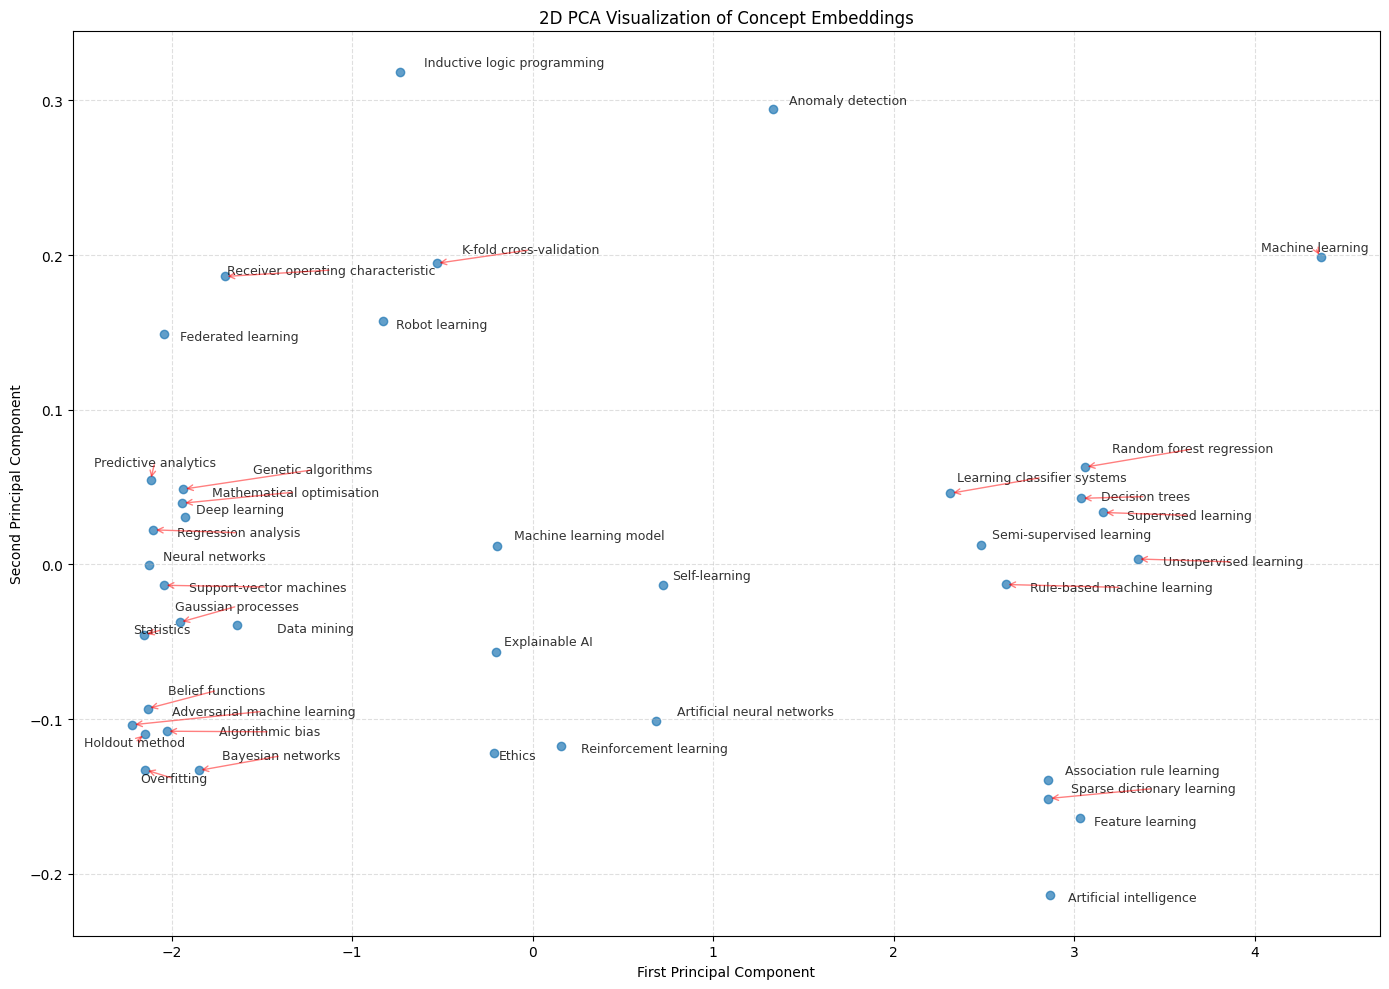

In [ ]:
visualize_entity_embeddings(x, mapped_node_names, "Concept")

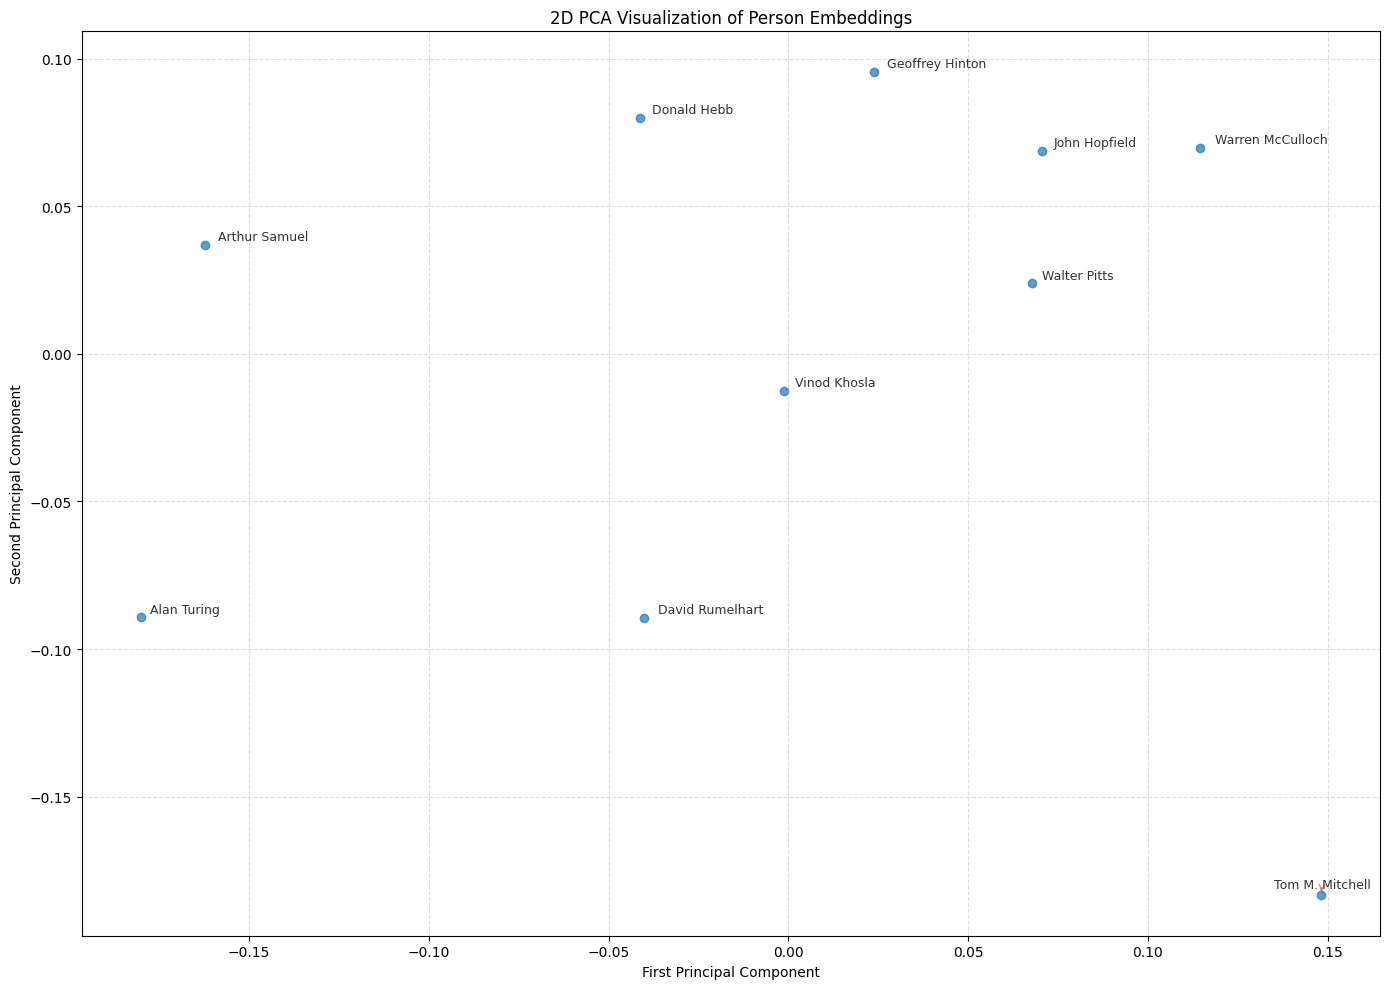

In [ ]:
visualize_entity_embeddings(x, mapped_node_names, "Person")